# Ноутбук по отбору признаков. Все вместе

In [1]:
from abc import ABC, abstractmethod
import copy

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, classification_report, f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.inspection import permutation_importance

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt
%matplotlib inline

import shap

import warnings
warnings.filterwarnings('ignore')

In [2]:
x, y = make_classification(
    n_samples=10000,
    n_features=100,
    n_informative=15,
    n_redundant=5,
    weights=(0.8, 0.1, 0.1),
    n_classes=3,
    n_repeated=5,
    n_clusters_per_class=4,
    shift=0.8,
    scale=3.0,
    shuffle=False)

In [3]:
cross_val_score(
    LGBMClassifier(verbose=-100), x, y, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring='f1_macro').mean()

0.625690108791336

In [4]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, stratify=y)

In [5]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [6]:
print(classification_report(y_val, model.predict(x_val)))

              precision    recall  f1-score   support

           0       0.86      1.00      0.92      2383
           1       0.76      0.32      0.45       307
           2       0.83      0.27      0.40       310

    accuracy                           0.85      3000
   macro avg       0.81      0.53      0.59      3000
weighted avg       0.84      0.85      0.82      3000



In [7]:
class BaseFeatureSelector(ABC):
    def __init__(self, n_folds=5):
        self.n_folds = n_folds
        self.importances = None

    def fit(self, x, y, **importances_kwargs):
        skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True)  # можно число фолдов и прочие параметры

        self.importances = pd.DataFrame({'feature': np.arange(x.shape[1])})

        for i, (train_index, val_index) in enumerate(skf.split(x, y)):
            x_train, y_train = x[train_index], y[train_index]
            x_val, y_val = x[val_index], y[val_index]

            model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
            model.fit(x_train, y_train, eval_set=(x_val, y_val))

            imp = self._get_importances_from_model(model, x_val, y_val, **importances_kwargs)

            self.importances[f'importance_{i}'] = imp

    def get_selected_features(self, threshold):
        assert self.importances is not None, 'Сначала нужно обучить, вызвав метод fit'

        # сделаем отдельно для 0 итерации
        imps = self.importances.loc[:, ['feature', 'importance_0']].sort_values('importance_0', ascending=False)  # выберем важности признаков с 0 итерации
        imps['importance_0'] /= imps['importance_0'].sum()
        imps['cumsum'] = imps['importance_0'].cumsum()  # так как мы их отнормировали, может посчитать кумулятивную сумму
        features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()  # возьмем только те признаки, которые по кумулятивной сумме удовлетворяют
        
        best_features = set(features)  # сделаем множество
        for i in range(1, self.n_folds):
            imps = self.importances.loc[:, ['feature', f'importance_{i}']].sort_values(f'importance_{i}', ascending=False)
            imps[f'importance_{i}'] /= imps[f'importance_{i}'].sum()
            imps['cumsum'] = imps[f'importance_{i}'].cumsum()
            features = imps.loc[imps['cumsum'] <= threshold, 'feature'].tolist()

            best_features &= set(features)  # смотрим на пересечения множеств на разных итерациях кросс-валидации

        return list(best_features)
        
    @abstractmethod
    def _get_importances_from_model(self, model, x, y, **kwargs):
        pass
    
    
class LGMFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, importance_type='split'):
        return model.booster_.feature_importance(importance_type=importance_type)
    

class ShapFeatureSelection(BaseFeatureSelector):
    def __init__(self, n_folds=5):
        super().__init__(n_folds)

    def _get_importances_from_model(self, model, x, y, 
                                    is_multiclass=False, feature_perturbation='tree_path_dependent'):
        explainer = shap.TreeExplainer(model, feature_perturbation=feature_perturbation)
        shap_values = explainer.shap_values(x)  # for each class, for each instance

        if is_multiclass:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = []
                for cls_ in shap_values:
                    cls_value = np.abs(cls_).mean(axis=0)
                    importances.append(cls_value.reshape(1, -1))
                    
                importances = np.concatenate(importances).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features, n_classes]
                importances = np.abs(shap_values).mean(axis=(0, 2))
        else:
            if isinstance(shap_values, list):
                # if shap_values in list of n_classes np.arrays of shape [n_samples, n_features]
                importances = np.abs(shap_values[1]).mean(axis=0)
            else:
                # if shap_values in np.array of shape [n_samples, n_features]
                importances = np.abs(shap_values).mean(axis=0)
        return importances

# Первый этап: отбираем признаки с помощью FeatureImportance и SHAP

In [8]:
lgm_fs = LGMFeatureSelection()
lgm_fs.fit(x, y)

In [9]:
shap_fs = ShapFeatureSelection()
shap_fs.fit(x, y, is_multiclass=True)

In [10]:
lgm_features = lgm_fs.get_selected_features(threshold=0.95)
shap_features = shap_fs.get_selected_features(threshold=0.95)

selected = set(lgm_features) & set(shap_features)
len(selected)

43

In [11]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train[:, list(selected)], y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [12]:
print(classification_report(y_val, model.predict(x_val[:, list(selected)])))

              precision    recall  f1-score   support

           0       0.87      0.99      0.92      2383
           1       0.77      0.39      0.52       307
           2       0.85      0.35      0.49       310

    accuracy                           0.86      3000
   macro avg       0.83      0.57      0.64      3000
weighted avg       0.86      0.86      0.84      3000



# Второй этап: пройдем по отобранным признакам жадным алгоритмом

In [13]:
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType

# удалим все признаки по очереди, пока не останется 1, чтобы посмотреть как ухудшается лосс
model = CatBoostClassifier(iterations=1000, verbose=False)
summary = model.select_features(
    x_train,
    y_train,
    eval_set=(x_val, y_val),
    features_for_select=list(selected),     # we will select from all features
    num_features_to_select=1,  # we want to select exactly important features
    steps=len(selected)-1,                                     # more steps - more accurate selection
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,            # can be Approximate, Regular and Exact
    train_final_model=False,                          # to train model with selected features
    logging_level='Silent',
    plot=False
)

In [14]:
summary

{'selected_features': [0],
 'eliminated_features_names': ['',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 'loss_graph': {'main_indices': [0,
   4,
   7,
   10,
   13,
   16,
   18,
   20,
   22,
   24,
   25,
   27,
   28,
   30,
   31,
   32,
   33,
   34,
   34,
   35,
   36,
   36,
   37,
   38,
   38,
   38,
   39,
   39,
   39,
   40,
   40,
   40,
   41,
   41,
   41,
   41,
   41,
   41,
   42,
   42,
   42,
   42],
  'removed_features_count': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42],
  'loss_values': [0.395682924407252,
   0.395543686

In [52]:
def get_feature_to_drop(model, x, features, feature_perturbation='tree_path_dependent'):
    explainer = shap.TreeExplainer(model, feature_perturbation=feature_perturbation)
    shap_values = explainer.shap_values(x)

#     importances = np.abs(shap_values)[:, :, 1].mean(axis=(0))
    importances = np.abs(shap_values).mean(axis=(0, 2))  # mean overall for multiclass
#     importances = model.booster_.feature_importance(importance_type='split')
    imps = pd.DataFrame({'feature': features, 'importance': importances})\
    .sort_values('importance', ascending=False).reset_index(drop=True)
    
    
    return imps, imps.iloc[-1]['feature']


def recursive_feature_elimination(model, x_train, y_train, x_val, y_val, k, features=None):
    n_features = x.shape[1]
    features = features or list(range(x.shape[1]))
    history = {
        'loss_values': [],
        'eliminated_features': [],
        'metrics': []
    }
    feature_to_delete = ''
    history['eliminated_features'].append(feature_to_delete)  # сначала ничего не удаляем и замеряем метрики
    
    while len(features) > k:
        print(f'Eliminated feature: {feature_to_delete}')
        model_ = copy.deepcopy(model)
        model_.fit(x_train[:, features], y_train, eval_set=(x_val, y_val))
        score = model_.best_score_['valid_0']
        history['loss_values'].append(score)
        
        imps, feature_to_delete = get_feature_to_drop(model_, x_val[:, features], features)
        
        metric = f1_score(y_val, model_.predict(x_val[:, features]), average="macro")
        history['metrics'].append(metric)
        
        print(imps.tail(5))
        print(f'F1 macro: {metric}')
        print(f'Loss: {score}')
        
        history['eliminated_features'].append(feature_to_delete)
        features.remove(feature_to_delete)
    
    # ---------------------------------------------------------
    # Финальный замер
    model_ = copy.deepcopy(model)
    model_.fit(x_train[:, features], y_train, eval_set=(x_val, y_val))
    score = model_.best_score_['valid_0']
    history['loss_values'].append(score)

    metric = f1_score(y_val, model_.predict(x_val[:, features]), average="macro")
    history['metrics'].append(metric)
    # ---------------------------------------------------------
    
    history['selected_features'] = features
    return history

In [53]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
summary_lgm = recursive_feature_elimination(model, x_train, y_train, x_val, y_val, features=list(selected), k=1)

Eliminated feature: 
    feature  importance
38       89    0.037067
39       77    0.035225
40       41    0.033966
41       49    0.033000
42       51    0.026256
F1 macro: 0.6440135928939711
Loss: OrderedDict([('multi_logloss', 0.42717932087377325)])
Eliminated feature: 51.0
    feature  importance
37       88    0.041004
38       77    0.038793
39       89    0.038350
40       41    0.035155
41       49    0.032454
F1 macro: 0.6472239296944591
Loss: OrderedDict([('multi_logloss', 0.43568457360404544)])
Eliminated feature: 49.0
    feature  importance
36       88    0.043405
37       77    0.042989
38       69    0.039606
39       89    0.037904
40       41    0.035145
F1 macro: 0.6412591227909672
Loss: OrderedDict([('multi_logloss', 0.4377025051236701)])
Eliminated feature: 41.0
    feature  importance
35       56    0.044378
36       89    0.043228
37       62    0.042031
38       77    0.041379
39       84    0.041160
F1 macro: 0.6415075523251311
Loss: OrderedDict([('multi_loglos

    feature  importance
6        12    0.285812
7        11    0.278092
8        19    0.273712
9         2    0.220255
10       17    0.209474
F1 macro: 0.6189451878081395
Loss: OrderedDict([('multi_logloss', 1.0477299950231171)])
Eliminated feature: 17.0
   feature  importance
5        4    0.283818
6       11    0.281665
7       19    0.257387
8        2    0.243314
9       12    0.235731
F1 macro: 0.6064670536656286
Loss: OrderedDict([('multi_logloss', 1.146066528902129)])
Eliminated feature: 12.0
   feature  importance
4        7    0.286986
5        6    0.275547
6        4    0.263228
7       19    0.251329
8        2    0.241811
F1 macro: 0.5716564928480838
Loss: OrderedDict([('multi_logloss', 1.076106218654181)])
Eliminated feature: 2.0
   feature  importance
3        7    0.307472
4       19    0.300790
5        6    0.295607
6       11    0.278337
7        4    0.275437
F1 macro: 0.5300343397341355
Loss: OrderedDict([('multi_logloss', 1.08942005965531)])
Eliminated feature: 

# Смотрим какие фичи дают максимальную метрику + минимальный лосс, обрежем

## Cat

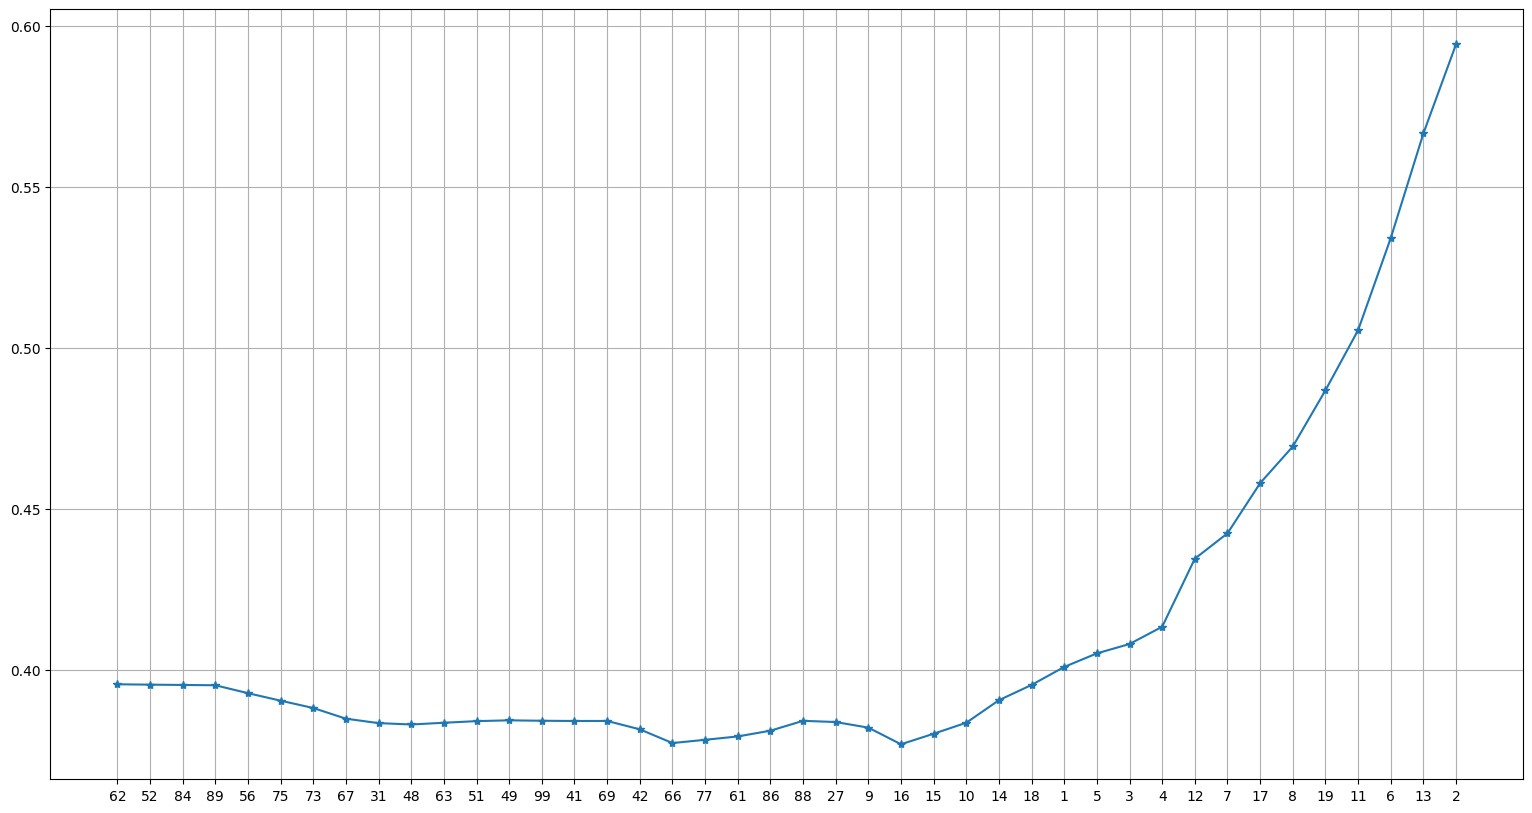

In [44]:
losses = summary['loss_graph']['loss_values'][1:]
plt.figure(figsize=(19, 10))
plt.plot(range(len(losses)), losses, '*-')
plt.xticks(ticks=range(len(losses)), labels=summary['eliminated_features'])
plt.grid(True);

In [72]:
# Видно, что минимум лосса приходится на признак 16, значит признаки до него включительно можно удалить

In [76]:
len(summary) - summary['eliminated_features'].index(16) + 1

-18

In [56]:
# но я удалю с запасом в 2 признака
summary_selected_cat = selected - set(summary['eliminated_features'][:-16])

In [57]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train[:, list(summary_selected_cat)], y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [58]:
print(classification_report(y_val, model.predict(x_val[:, list(summary_selected_cat)])))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2383
           1       0.77      0.51      0.62       307
           2       0.82      0.45      0.59       310

    accuracy                           0.88      3000
   macro avg       0.83      0.65      0.71      3000
weighted avg       0.88      0.88      0.87      3000



## LGM

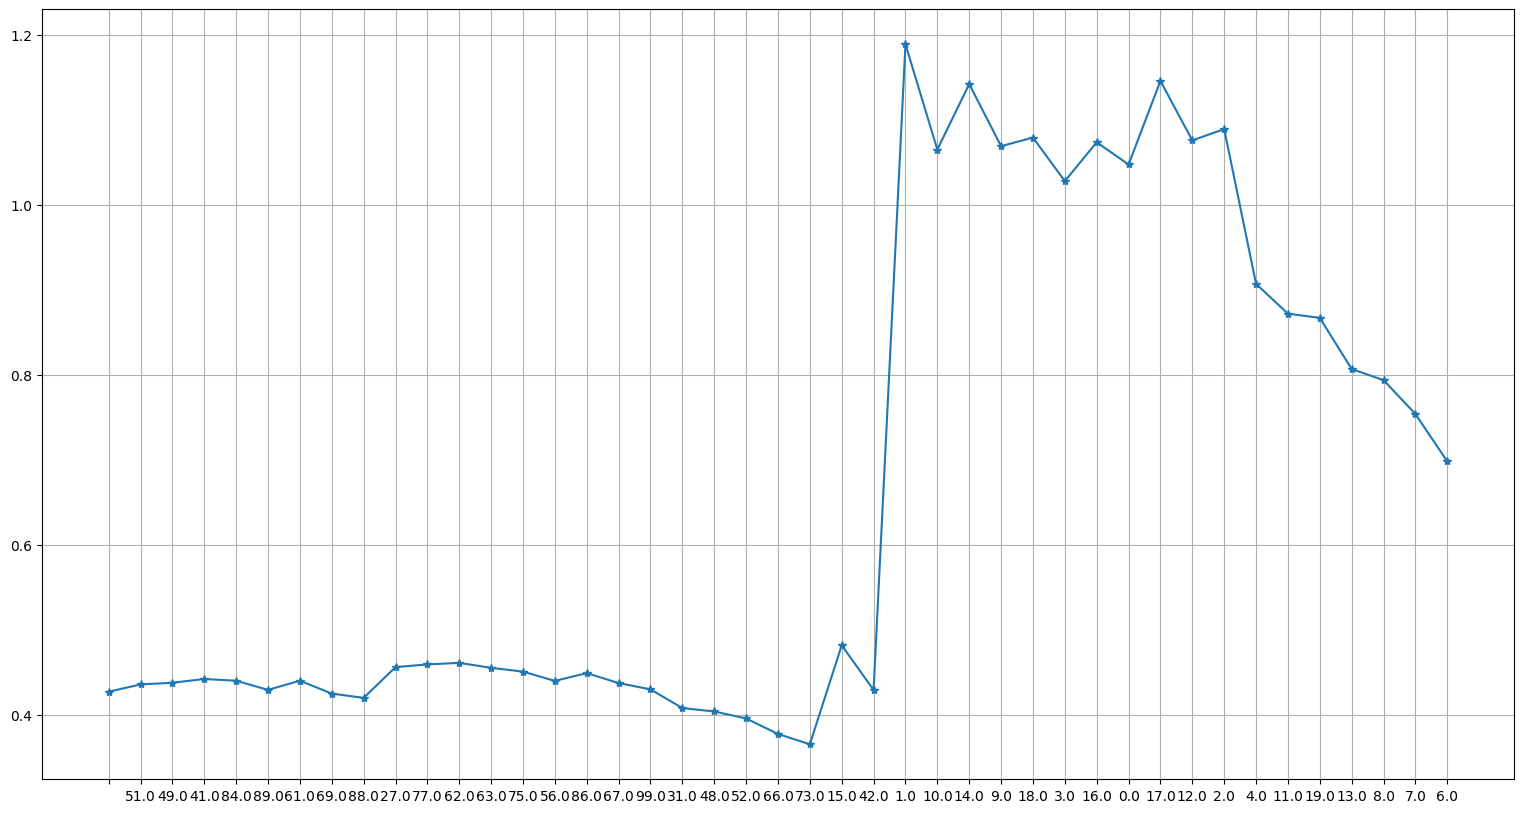

In [54]:
losses = [col['multi_logloss'] for col in summary_lgm['loss_values']]
plt.figure(figsize=(19, 10))
plt.plot(range(len(losses)), losses, '*-')
plt.xticks(ticks=range(len(losses)), labels=summary_lgm['eliminated_features'])
plt.grid(True);

In [59]:
summary_lgm['eliminated_features']

['',
 51.0,
 49.0,
 41.0,
 84.0,
 89.0,
 61.0,
 69.0,
 88.0,
 27.0,
 77.0,
 62.0,
 63.0,
 75.0,
 56.0,
 86.0,
 67.0,
 99.0,
 31.0,
 48.0,
 52.0,
 66.0,
 73.0,
 15.0,
 42.0,
 1.0,
 10.0,
 14.0,
 9.0,
 18.0,
 3.0,
 16.0,
 0.0,
 17.0,
 12.0,
 2.0,
 4.0,
 11.0,
 19.0,
 13.0,
 8.0,
 7.0,
 6.0]

In [71]:
# Видно, что с признака 1 начинает увеличиваться резко лосс и падать метрика

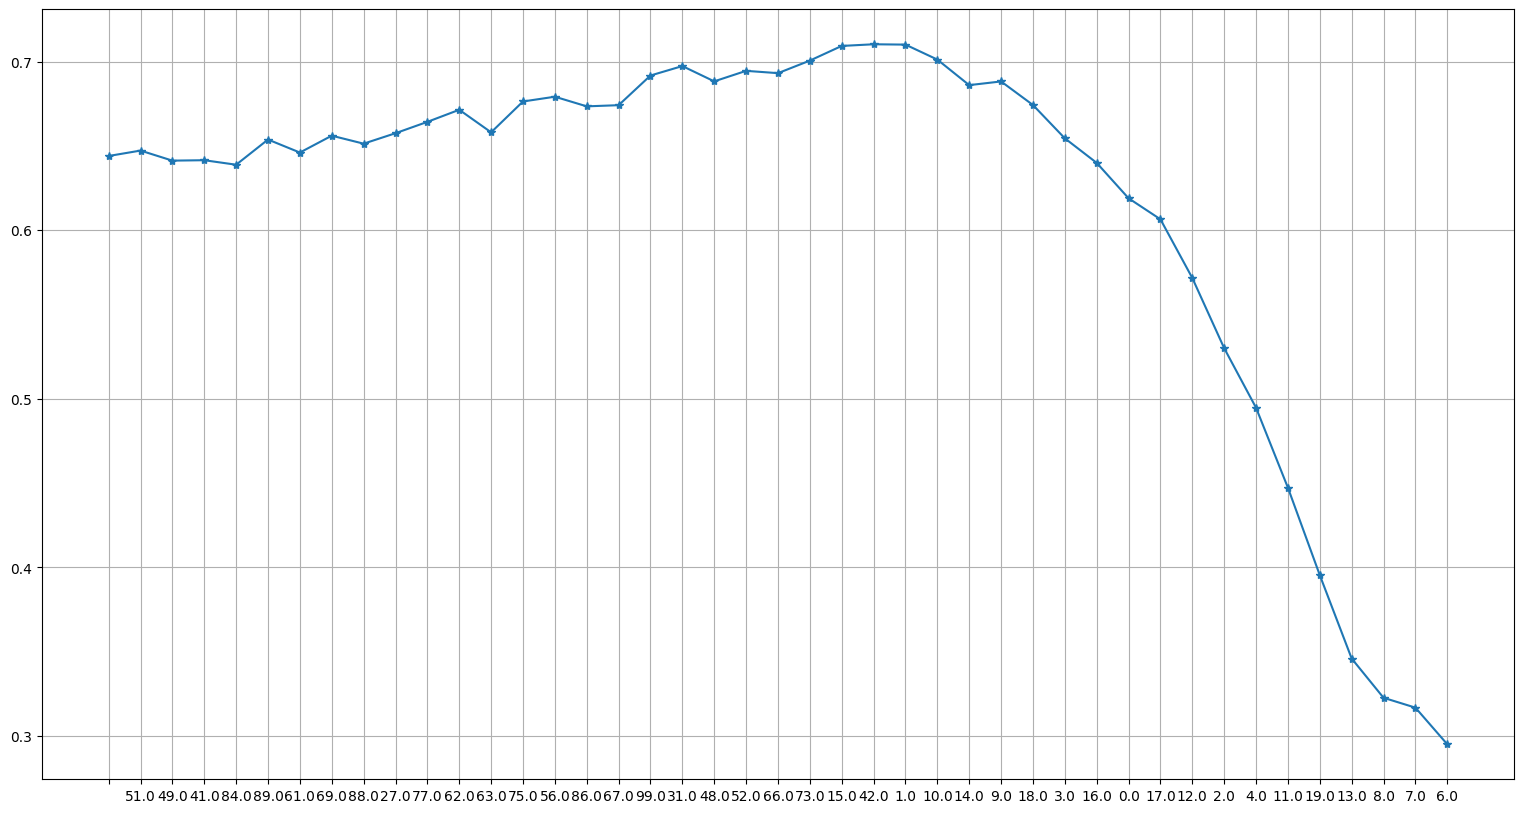

In [70]:
metrics = summary_lgm['metrics']
plt.figure(figsize=(19, 10))
plt.plot(range(len(metrics)), metrics, '*-')
plt.xticks(ticks=range(len(metrics)), labels=summary_lgm['eliminated_features'])
plt.grid(True);

In [60]:
summary_selected_lgm = selected - set(summary_lgm['eliminated_features'][:-18])

In [61]:
model = LGBMClassifier(max_depth=5, n_estimators=500, learning_rate=0.05, verbose=-100)
model.fit(x_train[:, list(summary_selected_lgm)], y_train)

LGBMClassifier(learning_rate=0.05, max_depth=5, n_estimators=500, verbose=-100)

In [62]:
print(classification_report(y_val, model.predict(x_val[:, list(summary_selected_lgm)])))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2383
           1       0.77      0.51      0.62       307
           2       0.87      0.43      0.58       310

    accuracy                           0.88      3000
   macro avg       0.84      0.64      0.71      3000
weighted avg       0.88      0.88      0.87      3000



In [67]:
summary_selected_cat - summary_selected_lgm

set()

In [68]:
summary_selected_cat

{0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19}

In [69]:
summary_selected_lgm

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 19}